# projective pruning

In [1]:
import os
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import scienceplots as _
import torch
import torch.nn.utils.prune as tprune
from scipy import stats
from sklearn.model_selection import ParameterGrid
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import Compose, Normalize, ToTensor

In [2]:
plt.style.use(["science", "nature"])

for dir in ["models", "figures", "results"]:
    if not os.path.exists(dir):
        os.makedirs(dir)

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"using {device} device")

using mps device


In [3]:
@torch.no_grad()
def validate_prune_step(
    W: torch.Tensor,
    b: torch.Tensor,
    V: torch.Tensor,
    amount: int,
):
    m = W.shape[1]
    n = W.shape[0]
    k = V.shape[0]

    assert W.shape == (n, m)
    assert b.shape == (n,)
    assert V.shape == (k, n)
    assert W.dtype == b.dtype == V.dtype
    assert W.device == b.device == V.device
    assert amount > 0 and amount < n


@torch.no_grad()
def solve_self_normal_eqs(W: torch.Tensor, lmbda: float):
    device = W.device
    dtype = W.dtype
    n = W.shape[0]

    G = W @ W.T
    G.diagonal().add_(lmbda)
    Gi = torch.inverse(G)
    Q = torch.zeros((n, n), dtype=dtype, device=device)
    for i in range(n):
        mask = torch.arange(n) != i
        a = Gi[mask][:, mask]
        c = Gi[i, mask]
        d = Gi[i, i]
        L = a - torch.ger(c / d, c)
        R = W[mask] @ W[i]
        Q[i, mask] = L @ R

    return Q


@torch.no_grad()
def proj_prune_iter(
    W: torch.Tensor,
    Q: torch.Tensor,
    amount: int,
    alpha: float,
    beta: float,
    gamma: float,
):
    device = W.device
    dtype = W.dtype
    n = W.shape[0]

    u_alpha = torch.ones(n, dtype=dtype, device=device)
    u_beta = torch.ones(n, dtype=dtype, device=device)
    u_gamma = torch.ones(n, dtype=dtype, device=device)

    M = torch.ones(n, dtype=torch.bool)
    for _ in range(amount):
        indices = torch.nonzero(M, as_tuple=True)[0]
        dists = torch.norm(Q[M] @ W - W[M], dim=1)
        i = indices[torch.argmin(dists)]

        u_alpha *= 1 + alpha * Q[i]
        u_beta *= 1 + beta * Q[i]
        u_gamma *= 1 + gamma * Q[i]

        M[i] = 0
        W[i] = 0
        Q[:, i] = 0
        Q[M] /= 1 + alpha * Q[i]

    return M, u_alpha, u_beta, u_gamma


@torch.no_grad()
def prune_step(
    W: torch.Tensor,
    b: torch.Tensor,
    V: torch.Tensor,
    amount: int,
    lmbda: float,
    alpha: float,
    beta: float,
    gamma: float,
):
    validate_prune_step(W, b, V, amount)

    Q = solve_self_normal_eqs(W, lmbda)
    M, ua, ub, ug = proj_prune_iter(W, Q, amount, alpha, beta, gamma)

    W_ = W[M] * ua[M].unsqueeze(1)
    b_ = b[M] * ub[M]
    V_ = V[:, M] * ug[M].unsqueeze(0)

    return W_, b_, V_


@torch.no_grad()
def prune(
    linears: list,
    prune_rates: list,
    *,
    lmbda: float = 1e-3,
    alpha: float = 0.5,
    beta: float = 0.5,
    gamma: float = 0.5,
):
    sequence = zip(linears[:-1], linears[1:], prune_rates)
    for layer, next_layer, prune_rate in sequence:
        W = layer.weight
        b = layer.bias
        V = next_layer.weight

        amount = int(W.shape[0] * prune_rate)
        W_, b_, V_ = prune_step(W, b, V, amount, lmbda=lmbda, alpha=alpha, beta=beta, gamma=gamma)

        layer.weight = torch.nn.Parameter(W_)
        layer.bias = torch.nn.Parameter(b_)
        next_layer.weight = torch.nn.Parameter(V_)

## Datasets


In [4]:
transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
train_set = datasets.FashionMNIST(root="data", train=True, transform=transform, download=True)
test_set = datasets.FashionMNIST(root="data", train=False, transform=transform, download=True)
train_set, val_set, _ = torch.utils.data.random_split(train_set, [20000, 20000, 20000])

BATCH_SIZE = 64
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

print(f"train data: {len(train_set)}")
print(f"val   data: {len(val_set)}")
print(f"test  data: {len(test_set)}")

train data: 20000
val   data: 20000
test  data: 10000


## Model


In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_block_0 = nn.Sequential(nn.Conv2d(1, 8, 3, 1), nn.ReLU(inplace=True), nn.MaxPool2d(2))
        self.conv_block_1 = nn.Sequential(nn.Conv2d(8, 16, 3, 1), nn.ReLU(inplace=True), nn.MaxPool2d(3))
        self.linear_block_0 = nn.Sequential(nn.Dropout(p=0.5), nn.Linear(16 * 3 * 3, 64), nn.ReLU(inplace=True))
        self.linear_block_1 = nn.Sequential(nn.Dropout(p=0.5), nn.Linear(64, 32), nn.ReLU(inplace=True))
        self.linear_block_2 = nn.Sequential(nn.Dropout(0.5), nn.Linear(32, 16), nn.ReLU(inplace=True))
        self.linear_block_3 = nn.Sequential(nn.Dropout(0.5), nn.Linear(16, 10))

    def forward(self, x):
        x = self.conv_block_0(x)
        x = self.conv_block_1(x)
        x = torch.flatten(x, 1)
        x = self.linear_block_0(x)
        x = self.linear_block_1(x)
        x = self.linear_block_2(x)
        x = self.linear_block_3(x)

        return x

## Training


In [6]:
criterion = nn.CrossEntropyLoss().to(device)


def train(model, optimizer, loader):
    model.train()

    for batch, (X, y) in enumerate(loader):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        pred_logits = model(X)
        loss = criterion(pred_logits, y)

        loss.backward()
        optimizer.step()


def evaluate(model, loader):
    model.eval()

    with torch.no_grad():
        size = len(loader.dataset)
        correct = 0

        for X, y in loader:
            X, y = X.to(device), y.to(device)

            pred_logits = model(X)
            pred = torch.argmax(pred_logits, dim=1)
            correct += (pred == y).sum()

        accuracy = correct / size
        return accuracy.item()


MODELS_PATH = "models"


def model_file(i):
    return Path(f"{MODELS_PATH}/model_{i}.pt")


def get_model(i):
    model = Net().to(device)
    model_path = model_file(i)
    model.load_state_dict(torch.load(model_path, weights_only=True, map_location=device))
    return model

In [7]:
MODELS_COUNT = 10
EPOCHS = 10

models = [Net().to(device) for i in range(MODELS_COUNT)]
optimizers = [optim.Adam(m.parameters(), lr=0.003) for m in models]
for i, (m, o) in enumerate(zip(models, optimizers)):
    model_path = model_file(i)
    if model_path.is_file():
        m.load_state_dict(torch.load(model_path, weights_only=True, map_location=device))
    else:
        for n in range(EPOCHS):
            train(m, o, train_loader)
            accuracy = evaluate(m, val_loader)
        torch.save(m.state_dict(), model_path)

## Pruning after training (PAT)


In [8]:
params = {"amount": [i / 10 for i in range(10)]}

### Random pruning

In [9]:
random_data = []
filename = "results/random.pkl"

if Path(filename).is_file():
    with open(filename, "rb") as f:
        random_data = pickle.load(f)

else:
    for i in range(MODELS_COUNT):
        data = []
        for param in ParameterGrid(params):
            amount = param["amount"]
            model = get_model(i)
            tprune.random_structured(model.linear_block_0[1], name="weight", amount=amount, dim=1)
            tprune.random_structured(model.linear_block_1[1], name="weight", amount=amount, dim=1)
            tprune.random_structured(model.linear_block_2[1], name="weight", amount=amount, dim=1)
            acc = evaluate(model, test_loader)
            data.append(acc)
        random_data.append(data)

    with open(filename, "wb") as f:
        pickle.dump(random_data, f)

### L1 norm pruning


In [10]:
l1_data = []
filename = "results/l1.pkl"

if Path(filename).is_file():
    with open(filename, "rb") as f:
        l1_data = pickle.load(f)

else:
    for i in range(MODELS_COUNT):
        data = []
        for param in ParameterGrid(params):
            amount = param["amount"]
            model = get_model(i)
            tprune.ln_structured(model.linear_block_0[1], name="weight", amount=amount, n=1, dim=1)
            tprune.ln_structured(model.linear_block_1[1], name="weight", amount=amount, n=1, dim=1)
            tprune.ln_structured(model.linear_block_2[1], name="weight", amount=amount, n=1, dim=1)
            acc = evaluate(model, test_loader)
            data.append(acc)
        l1_data.append(data)

    with open(filename, "wb") as f:
        pickle.dump(l1_data, f)

### L2 norm pruning


In [11]:
l2_data = []
filename = "results/l2.pkl"

if Path(filename).is_file():
    with open(filename, "rb") as f:
        l2_data = pickle.load(f)

else:
    for i in range(MODELS_COUNT):
        data = []
        for param in ParameterGrid(params):
            amount = param["amount"]
            model = get_model(i)
            tprune.ln_structured(model.linear_block_0[1], name="weight", amount=amount, n=2, dim=1)
            tprune.ln_structured(model.linear_block_1[1], name="weight", amount=amount, n=2, dim=1)
            tprune.ln_structured(model.linear_block_2[1], name="weight", amount=amount, n=2, dim=1)
            acc = evaluate(model, test_loader)
            data.append(acc)
        l2_data.append(data)

    with open(filename, "wb") as f:
        pickle.dump(l2_data, f)

### Projective pruning without recasting

In [12]:
def experiment_our_model(alpha, beta, gamma, filename, lmbda=1e-3):
    results = []
    if Path(filename).is_file():
        with open(filename, "rb") as f:
            results = pickle.load(f)

    else:
        for i in range(MODELS_COUNT):
            model = get_model(i)
            arr = [1, 1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
            data = []
            for i in range(10):
                factor = arr[i + 1] / arr[i]
                if 1 - factor != 0:
                    prune(
                        [
                            model.linear_block_0[1],
                            model.linear_block_1[1],
                            model.linear_block_2[1],
                            model.linear_block_3[1],
                        ],
                        [1 - factor, 1 - factor, 1 - factor],
                        lmbda=lmbda,
                        alpha=alpha,
                        beta=beta,
                        gamma=gamma,
                    )
                acc = evaluate(model, test_loader)
                data.append(acc)
            results.append(data)
        with open(filename, "wb") as f:
            pickle.dump(results, f)

    return results


proj_noreadj_data = experiment_our_model(0, 0, 0, "results/proj_noreadj.pkl")

### Projective pruning with first layer recasting


In [13]:
proj_wb_readj_data = experiment_our_model(0.5, 0.5, 0, "results/proj_wb_readj.pkl")

### Projective pruning with complete recasting


In [14]:
proj_complete_readj_data = experiment_our_model(0.5, 0.5, 0.5, "results/proj_complete_readj.pkl")

## Gather stats


In [15]:
alpha_crit = 0.05
t_value = stats.t.ppf(1 - alpha_crit / 2, df=MODELS_COUNT - 1)


def get_stats(raw_data):
    data = []
    for l, d in raw_data:
        d = np.array(d)
        avg = np.mean(d, axis=0)

        errors = []
        for i in range(d.shape[1]):
            errors.append(stats.sem(d[:, i]) * t_value)  # 95% confidence interval
        errors = np.array(errors)

        data.append((l, avg, errors))
    return data

## Comparison plot


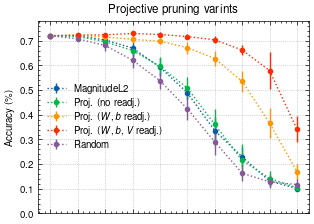

In [16]:
data = [
    ["MagnitudeL2", l2_data],
    ["Proj. (no readj.)", proj_noreadj_data],
    ["Proj. ($W,b$ readj.)", proj_wb_readj_data],
    ["Proj. ($W,b,V$ readj.)", proj_complete_readj_data],
    ["Random", random_data],
]
data = get_stats(data)

fig, ax = plt.subplots(figsize=(3.5, 2.5))

for label, avg, errors in data:
    ax.errorbar(
        [i / 10 for i in range(10)],
        avg,
        yerr=errors,
        label=label,
        linestyle="dotted",
        marker="o",
    )

ax.grid(linestyle="dotted")
ax.legend(loc="center left")
ax.set_ylabel("Accuracy (\\%)")
ax.set_xticks([i / 10 for i in range(10)])
ax.set_ylim(0.0, 0.78)
ax.set_title("Projective pruning varints")
ax.tick_params(labelbottom=False)

plt.savefig("figures/compare.svg")

### Hyperparameter exploration

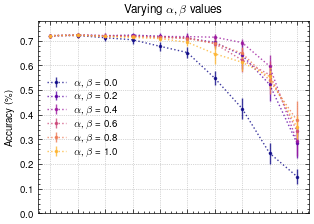

In [17]:
results = []
for ab in [j / 10 for j in range(0, 11, 2)]:
    filename = f"results/proj_alphabeta_{ab}.pkl"
    if Path(filename).is_file():
        with open(filename, "rb") as f:
            data = pickle.load(f)
    else:
        data = experiment_our_model(ab, ab, 0.5, filename)
        with open(filename, "wb") as f:
            pickle.dump(data, f)
    results.append((None, data))
data = get_stats(results)

fig, ax = plt.subplots(figsize=(3.5, 2.5))

cmap = plt.get_cmap("plasma", 7)
for alpha, (_, avg, errors) in zip(range(0, 11, 2), data):
    ax.errorbar(
        [i / 10 for i in range(10)],
        avg,
        yerr=errors,
        label=rf"$\alpha,\beta = {alpha / 10}$",
        linestyle="dotted",
        marker=".",
        color=cmap(int(alpha / 2)),
        alpha=0.8,
    )

ax.grid(linestyle="dotted")
ax.legend(loc="center left")
ax.set_ylabel("Accuracy (\\%)")
ax.set_xticks([i / 10 for i in range(10)])
ax.set_ylim(0.0, 0.78)
ax.set_title(r"Varying $\alpha, \beta$ values")
ax.tick_params(labelbottom=False)

plt.savefig("figures/alphabeta.svg")
plt.show()

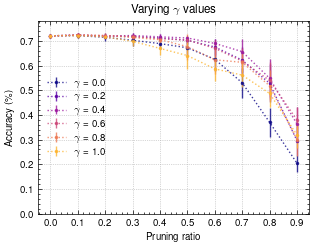

In [18]:
results = []
for g in [j / 10 for j in range(0, 11, 2)]:
    filename = f"results/proj_gamma_{g}.pkl"
    if Path(filename).is_file():
        with open(filename, "rb") as f:
            data = pickle.load(f)
    else:
        data = experiment_our_model(0.5, 0.5, g, filename)
        with open(filename, "wb") as f:
            pickle.dump(data, f)
    results.append((None, data))
data = get_stats(results)

fig, ax = plt.subplots(figsize=(3.5, 2.5))

cmap = plt.get_cmap("plasma", 7)
for gamma, (_, avg, errors) in zip(range(0, 11, 2), data):
    ax.errorbar(
        [i / 10 for i in range(10)],
        avg,
        yerr=errors,
        label=rf"$\gamma = {gamma / 10}$",
        linestyle="dotted",
        marker=".",
        color=cmap(int(gamma / 2)),
        alpha=0.8,
    )

ax.grid(linestyle="dotted")
ax.legend(loc="center left")
ax.set_xlabel("Pruning ratio")
ax.set_ylabel("Accuracy (\\%)")
ax.set_xticks([i / 10 for i in range(10)])
ax.set_ylim(0.0, 0.78)
ax.set_title(r"Varying $\gamma$ values")

plt.savefig("figures/gamma.svg")
plt.show()

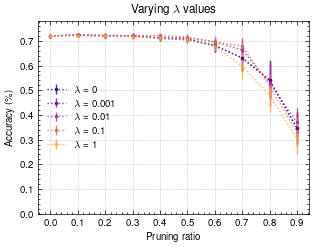

In [19]:
results = []
for lmbda in [0, 1e-3, 1e-2, 1e-1, 1, 10]:
    filename = f"results/proj_lambda_{lmbda}.pkl"
    if Path(filename).is_file():
        with open(filename, "rb") as f:
            data = pickle.load(f)
    else:
        data = experiment_our_model(0.5, 0.5, 0.5, filename, lmbda=lmbda)
        with open(filename, "wb") as f:
            pickle.dump(data, f)
    results.append((None, data))
data = get_stats(results)

fig, ax = plt.subplots(figsize=(3.5, 2.5))

cmap = plt.get_cmap("plasma", 6)
for i, lmbda, (_, avg, errors) in zip(range(5), [0, 1e-3, 1e-2, 1e-1, 1, 10], data):
    ax.errorbar(
        [i / 10 for i in range(10)],
        avg,
        yerr=errors,
        label=rf"$\lambda = {lmbda}$",
        linestyle="dotted",
        marker=".",
        color=cmap(i),
        alpha=0.8,
    )

ax.grid(linestyle="dotted")
ax.legend(loc="center left")
ax.set_xlabel("Pruning ratio")
ax.set_ylabel("Accuracy (\\%)")
ax.set_xticks([i / 10 for i in range(10)])
ax.set_ylim(0.0, 0.78)
ax.set_title(r"Varying $\lambda$ values")

plt.savefig("figures/lmbda.svg")
plt.show()

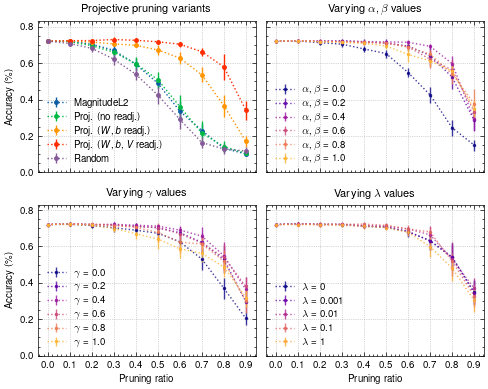

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(5, 4), sharex=True, sharey=True, layout="tight")

ax = axes[0][0]
data = [
    ["MagnitudeL2", l2_data],
    ["Proj. (no readj.)", proj_noreadj_data],
    ["Proj. ($W,b$ readj.)", proj_wb_readj_data],
    ["Proj. ($W,b,V$ readj.)", proj_complete_readj_data],
    ["Random", random_data],
]
data = get_stats(data)
for label, avg, errors in data:
    ax.errorbar(
        [i / 10 for i in range(10)],
        avg,
        yerr=errors,
        label=label,
        linestyle="dotted",
        marker=".",
        markersize=5,
    )
ax.grid(linestyle="dotted")
ax.legend(loc="lower left")
ax.set_ylabel("Accuracy (\\%)")
ax.set_xticks([i / 10 for i in range(10)])
ax.set_ylim(0.0, 0.78)
ax.set_title("Projective pruning variants", fontsize=8)
ax.tick_params(labelbottom=False)

ax = axes[0][1]
results = []
for ab in [j / 10 for j in range(0, 11, 2)]:
    filename = f"results/proj_alphabeta_{ab}.pkl"
    if Path(filename).is_file():
        with open(filename, "rb") as f:
            data = pickle.load(f)
    else:
        data = experiment_our_model(ab, ab, 0.5, filename)
        with open(filename, "wb") as f:
            pickle.dump(data, f)
    results.append((None, data))
data = get_stats(results)
cmap = plt.get_cmap("plasma", 7)
for alpha, (_, avg, errors) in zip(range(0, 11, 2), data):
    ax.errorbar(
        [i / 10 for i in range(10)],
        avg,
        yerr=errors,
        label=rf"$\alpha,\beta = {alpha / 10}$",
        linestyle="dotted",
        marker=".",
        color=cmap(int(alpha / 2)),
        alpha=0.8,
    )
ax.grid(linestyle="dotted")
ax.legend(loc="lower left")
ax.set_xticks([i / 10 for i in range(10)])
ax.set_ylim(0.0, 0.78)
ax.set_title(r"Varying $\alpha, \beta$ values", fontsize=8)
ax.tick_params(labelbottom=False)

ax = axes[1][0]
results = []
for g in [j / 10 for j in range(0, 11, 2)]:
    filename = f"results/proj_gamma_{g}.pkl"
    if Path(filename).is_file():
        with open(filename, "rb") as f:
            data = pickle.load(f)
    else:
        data = experiment_our_model(0.5, 0.5, g, filename)
        with open(filename, "wb") as f:
            pickle.dump(data, f)
    results.append((None, data))
data = get_stats(results)
cmap = plt.get_cmap("plasma", 7)
for gamma, (_, avg, errors) in zip(range(0, 11, 2), data):
    ax.errorbar(
        [i / 10 for i in range(10)],
        avg,
        yerr=errors,
        label=rf"$\gamma = {gamma / 10}$",
        linestyle="dotted",
        marker=".",
        color=cmap(int(gamma / 2)),
        alpha=0.8,
    )
ax.grid(linestyle="dotted")
ax.legend(loc="lower left")
ax.set_xlabel("Pruning ratio")
ax.set_ylabel("Accuracy (\\%)")
ax.set_xticks([i / 10 for i in range(10)])
ax.set_ylim(0.0, 0.78)
ax.set_title(r"Varying $\gamma$ values", fontsize=8)

ax = axes[1][1]
results = []
for lmbda in [0, 1e-3, 1e-2, 1e-1, 1, 10]:
    filename = f"results/proj_lambda_{lmbda}.pkl"
    if Path(filename).is_file():
        with open(filename, "rb") as f:
            data = pickle.load(f)
    else:
        data = experiment_our_model(0.5, 0.5, 0.5, filename, lmbda=lmbda)
        with open(filename, "wb") as f:
            pickle.dump(data, f)
    results.append((None, data))
data = get_stats(results)
cmap = plt.get_cmap("plasma", 6)
for i, lmbda, (_, avg, errors) in zip(range(5), [0, 1e-3, 1e-2, 1e-1, 1, 10], data):
    ax.errorbar(
        [i / 10 for i in range(10)],
        avg,
        yerr=errors,
        label=rf"$\lambda = {lmbda}$",
        linestyle="dotted",
        marker=".",
        color=cmap(i),
        alpha=0.8,
    )
ax.grid(linestyle="dotted")
ax.legend(loc="lower left")
ax.set_xlabel("Pruning ratio")
ax.set_xticks([i / 10 for i in range(10)])
ax.set_ylim(0.0, 0.83)
ax.set_title(r"Varying $\lambda$ values", fontsize=8)

plt.savefig("figures/param_fmnist.svg")